Para realizar las importaciones necesarias, se debe agregar la referencia del repositorio de Github en la libreta para que tenga a su disposición los archivos del mismo

In [2]:
!git clone https://github.com/DenisPerez/NN_Tests_DG.git
%cd NN_Tests_DG
%ls

Cloning into 'NN_Tests_DG'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 48 (delta 16), reused 37 (delta 7), pack-reused 0
Unpacking objects: 100% (48/48), 12.49 MiB | 5.12 MiB/s, done.
/content/NN_Tests_DG
Dataset/          Iteracion1_new.ipynb     NN_Pytorch.ipynb
Decay.ipynb       Iteracion_2.ipynb        requirement.txt
get_images.py     LearningRateStudy.ipynb  SGD_Momentum_RMSProp_Adam.ipynb
Iteracion1.ipynb  NN_from_Scratch.ipynb


Se realizan las importaciones requeridas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Images

In [4]:
MNIST_PATH = './Dataset/'

In [5]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [6]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

## Normalize images

In [7]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [8]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [9]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

## Show Images

In [10]:
x_test.shape

(10000, 784)

In [11]:
y_train.shape

(50000, 1)

In [12]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


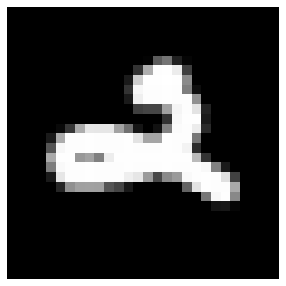

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Create Mini Batches

In [14]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Pytorch 

In [15]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

## Use GPU when available

In [16]:
torch.cuda.is_available()

True

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Accuracy

In [18]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

# Train

In [19]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    epoch_acc = 0.0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (epoch_acc < 0.95 and i < 100):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr = optimizer.param_groups[0]['lr']
          lr_list.append(lr)
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        print(f'Epoch: {len(acc_list)}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list

## List Operations

In [20]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

In [21]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [22]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

# Experiments

### Variables globales

In [23]:
MAX_ITERATIONS = 5

layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}


## Fija

In [24]:
def Fixed():
    modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


    start.record()
    fixed_acc_list, fixed_cost_list, fixed_lr_list = train(modelFixed, optimizer,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    fixed_time = start.elapsed_time(end)

    fixed_acc = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

    return fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc


In [51]:

resultados['fixed'] = {}
resultados['fixed']['val_acc_list'] = [0] * epochs
resultados['fixed']['test_acc'] = 0
resultados['fixed']['cost'] = [0] * epochs
resultados['fixed']['time'] = 0


for _ in range(MAX_ITERATIONS):
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc = Fixed()
    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)
    resultados['fixed']['test_acc'] += fixed_acc
    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)
    resultados['fixed']['time'] += fixed_time

#Saving results
resultados['fixed']['name'] = 'Fijo'
resultados['fixed']['lr'] = fixed_lr_list
resultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS
resultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))
resultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))
resultados['fixed']['time'] = resultados['fixed']['time'] 


"\nfor _ in range(MAX_ITERATIONS):\n    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc = Fixed()\n    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)\n    resultados['fixed']['test_acc'] += fixed_acc\n    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)\n    resultados['fixed']['time'] += fixed_time\n\n#Saving results\nresultados['fixed']['name'] = 'Fijo'\nresultados['fixed']['lr'] = fixed_lr_list\nresultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS\nresultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))\nresultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))\nresultados['fixed']['time'] = resultados['fixed']['time'] \n"

## Decreciente (Pytorch)

In [26]:
def Decay():
    modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1, verbose=False)

    start.record()
    decay_acc_list, decay_cost_list, decay_lr_list = train(modelDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    decay_time = start.elapsed_time(end)

    decay_acc = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)
    
    return decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc

In [52]:

resultados['decay'] = {}
resultados['decay']['val_acc_list'] = [0] * epochs
resultados['decay']['test_acc'] = 0
resultados['decay']['cost'] = [0] * epochs
resultados['decay']['time'] = 0


for _ in range(MAX_ITERATIONS):
    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc = Decay()
    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)
    resultados['decay']['test_acc'] += decay_acc
    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)
    resultados['decay']['time'] += decay_time

#Saving results
resultados['decay']['name'] = 'Decreciente'
resultados['decay']['lr'] = decay_lr_list
resultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS
resultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))
resultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))
resultados['decay']['time'] = resultados['decay']['time'] 


"\nfor _ in range(MAX_ITERATIONS):\n    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc = Decay()\n    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)\n    resultados['decay']['test_acc'] += decay_acc\n    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)\n    resultados['decay']['time'] += decay_time\n\n#Saving results\nresultados['decay']['name'] = 'Decreciente'\nresultados['decay']['lr'] = decay_lr_list\nresultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS\nresultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))\nresultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))\nresultados['decay']['time'] = resultados['decay']['time'] \n"

## Cyclic Vanilla

In [28]:
def Cyclic():
    modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list= train(modelCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclic_time = start.elapsed_time(end)

    cyclic_acc = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

    return cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc

In [29]:
resultados['cyclic'] = {}
resultados['cyclic']['val_acc_list'] = [0]* epochs
resultados['cyclic']['test_acc'] = 0
resultados['cyclic']['cost'] = [0] * epochs
resultados['cyclic']['time'] = 0

for _ in range(MAX_ITERATIONS):
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc = Cyclic()
    resultados['cyclic']['val_acc_list'] = SumList(resultados['cyclic']['val_acc_list'], cyclic_acc_list)
    resultados['cyclic']['test_acc'] += cyclic_acc
    resultados['cyclic']['cost'] = SumList(resultados['cyclic']['cost'], cyclic_cost_list)
    resultados['cyclic']['time'] += cyclic_time

#Saving results
resultados['cyclic']['name'] = 'Ciclico'
resultados['cyclic']['lr'] = cyclic_lr_list
resultados['cyclic']['test_acc'] = resultados['cyclic']['test_acc'] / MAX_ITERATIONS
resultados['cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclic']['cost'], MAX_ITERATIONS))
resultados['cyclic']['time'] = resultados['cyclic']['time'] 

Epoch: 2, learning_rate:[0.040000000000000015],costo: 2.249220848083496, accuracy: 0.25537109375
Epoch: 3, learning_rate:[0.06999999999999999],costo: 1.9333337545394897, accuracy: 0.730224609375
Epoch: 4, learning_rate:[0.1],costo: 1.1265145540237427, accuracy: 0.81689453125
Epoch: 5, learning_rate:[0.07000000000000003],costo: 0.6498629450798035, accuracy: 0.75
Epoch: 6, learning_rate:[0.03999999999999998],costo: 0.5021170377731323, accuracy: 0.885498046875
Epoch: 7, learning_rate:[0.01],costo: 0.4627567529678345, accuracy: 0.897216796875
Epoch: 8, learning_rate:[0.040000000000000056],costo: 0.4480934739112854, accuracy: 0.89453125
Epoch: 9, learning_rate:[0.06999999999999995],costo: 0.39543336629867554, accuracy: 0.899658203125
Epoch: 10, learning_rate:[0.1],costo: 0.38781875371932983, accuracy: 0.894775390625
Epoch: 11, learning_rate:[0.06999999999999995],costo: 0.37949833273887634, accuracy: 0.8974609375
Epoch: 12, learning_rate:[0.040000000000000056],costo: 0.339735746383667, accur

## Cyclic Class

In [30]:
from torch.optim import Optimizer

import types
import math
from torch._six import inf
from functools import wraps
import warnings
import weakref
import random

class _LRSchedulerGiselt_Denis(object):

    def __init__(self, optimizer, last_epoch=-1, verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]
        self.last_epoch = last_epoch

        # Following https://github.com/pytorch/pytorch/issues/20124
        # We would like to ensure that `lr_scheduler.step()` is called after
        # `optimizer.step()`
        def with_counter(method):
            if getattr(method, '_with_counter', False):
                # `optimizer.step()` has already been replaced, return.
                return method

            # Keep a weak reference to the optimizer instance to prevent
            # cyclic references.
            instance_ref = weakref.ref(method.__self__)
            # Get the unbound method for the same purpose.
            func = method.__func__
            cls = instance_ref().__class__
            del method

            @wraps(func)
            def wrapper(*args, **kwargs):
                instance = instance_ref()
                instance._step_count += 1
                wrapped = func.__get__(instance, cls)
                return wrapped(*args, **kwargs)

            # Note that the returned function here is no longer a bound method,
            # so attributes like `__func__` and `__self__` no longer exist.
            wrapper._with_counter = True
            return wrapper

        self.optimizer.step = with_counter(self.optimizer.step)
        self.verbose = verbose

        self._initial_step()

    def _initial_step(self):
        """Initialize step counts and performs a step"""
        self.optimizer._step_count = 0
        self._step_count = 0
        self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Args:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_last_lr(self):
        """ Return last computed learning rate by current scheduler.
        """
        return self._last_lr

    def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        raise NotImplementedError

    def print_lr(self, is_verbose, group, lr, epoch=None):
        """Display the current learning rate.
        """
        if is_verbose:
            if epoch is None:
                print('Adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(group, lr))
            else:
                epoch_str = ("%.2f" if isinstance(epoch, float) else
                             "%.5d") % epoch
                print('Epoch {}: adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(epoch_str, group, lr))


    def step(self, epoch=None):
        # Raise a warning if old pattern is detected
        # https://github.com/pytorch/pytorch/issues/20124
        if self._step_count == 1:
            if not hasattr(self.optimizer.step, "_with_counter"):
                warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
                              "initialization. Please, make sure to call `optimizer.step()` before "
                              "`lr_scheduler.step()`. See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

            # Just check if there were two first lr_scheduler.step() calls before optimizer.step()
            elif self.optimizer._step_count < 1:
                warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
                              "In PyTorch 1.1.0 and later, you should call them in the opposite order: "
                              "`optimizer.step()` before `lr_scheduler.step()`.  Failure to do this "
                              "will result in PyTorch skipping the first value of the learning rate schedule. "
                              "See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
        self._step_count += 1

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False

        with _enable_get_lr_call(self):
            if epoch is None:
                self.last_epoch += 1
                values = self.get_lr()
            else:
                warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                self.last_epoch = epoch
                if hasattr(self, "_get_closed_form_lr"):
                    values = self._get_closed_form_lr()
                else:
                    values = self.get_lr()

        for i, data in enumerate(zip(self.optimizer.param_groups, values)):
            param_group, lr = data
            param_group['lr'] = lr
            self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

class CyclicLRGiselt_Denis(_LRSchedulerGiselt_Denis):
    r"""Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.

    Cyclical learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.

    This class has three built-in policies, as put forth in the paper:

    * "triangular": A basic triangular cycle without amplitude scaling.
    * "triangular2": A basic triangular cycle that scales initial amplitude by half each cycle.
    * "exp_range": A cycle that scales initial amplitude by :math:`\text{gamma}^{\text{cycle iterations}}`
      at each cycle iteration.

    This implementation was adapted from the github repo: `bckenstler/CLR`_

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for each parameter group.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size_up (int): Number of training iterations in the
            increasing half of a cycle. Default: 2000
        step_size_down (int): Number of training iterations in the
            decreasing half of a cycle. If step_size_down is None,
            it is set to step_size_up. Default: None
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            If specified, then 'mode' is ignored.
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Lower momentum boundaries in the cycle
            for each parameter group. Note that momentum is cycled inversely
            to learning rate; at the peak of a cycle, momentum is
            'base_momentum' and learning rate is 'max_lr'.
            Default: 0.8
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            The momentum at any cycle is the difference of max_momentum
            and some scaling of the amplitude; therefore
            base_momentum may not actually be reached depending on
            scaling function. Note that momentum is cycled inversely
            to learning rate; at the start of a cycle, momentum is 'max_momentum'
            and learning rate is 'base_lr'
            Default: 0.9
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.

    Example:
        >>> # xdoctest: +SKIP
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()


    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self,
                 optimizer,
                 base_lr,
                 max_lr,
                 step_size_up=2000,
                 step_size_down=None,
                 mode='triangular',
                 gamma=1.,
                 scale_fn=None,
                 scale_mode='cycle',
                 cycle_momentum=True,
                 base_momentum=0.8,
                 max_momentum=0.9,
                 last_epoch=-1,
                 verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        
        self.direction_up = True
        self.half_cycle_steps = 0

        base_lrs = self._format_param('base_lr', optimizer, base_lr)
        if last_epoch == -1:
            for lr, group in zip(base_lrs, optimizer.param_groups):
                group['lr'] = lr

        self.max_lrs = self._format_param('max_lr', optimizer, max_lr)

        self.step_size_up = float(step_size_up)
        self.step_size_down = float(step_size_down) if step_size_down is not None else step_size_up
        self.total_size = self.step_size_up + self.step_size_down
        self.step_ratio = step_size_up / self.total_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            self._scale_fn_custom = None
            if self.mode == 'triangular':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self._scale_fn_ref = weakref.WeakMethod(self._triangular2_scale_fn)
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self._scale_fn_ref = weakref.WeakMethod(self._exp_range_scale_fn)
                self.scale_mode = 'iterations'
        else:
            self._scale_fn_custom = scale_fn
            self._scale_fn_ref = None
            self.scale_mode = scale_mode

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
            self.base_momentums = [group['momentum'] for group in optimizer.param_groups]
            self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)

        super(CyclicLRGiselt_Denis, self).__init__(optimizer, last_epoch, verbose)
        self.base_lrs = base_lrs

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def scale_fn(self, x):
        if self._scale_fn_custom is not None:
            # print(self.half_cycle_steps, x)
            return self._scale_fn_custom(x)

        else:
            return self._scale_fn_ref()(x)

    def scale_fn_rand(self, x, y):
        return random.uniform(x, y)

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        """Calculates the learning rate at batch index. This function treats
        `self.last_epoch` as the last batch index.

        If `self.cycle_momentum` is ``True``, this function has a side effect of
        updating the optimizer's momentum.
        """
        

        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        cycle = math.floor(1 + self.last_epoch / self.total_size)
        x = 1. + self.last_epoch / self.total_size - cycle
        if x <= self.step_ratio:
            scale_factor = x / self.step_ratio
        else:
            scale_factor = (x - 1) / (self.step_ratio - 1)

        lrs = []
        for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
            base_height = (max_lr - base_lr) * scale_factor
            if self.scale_mode == 'cycle':

                # print("cycle")
                lr = base_lr + base_height * self.scale_fn(cycle)
            elif self.scale_mode == 'iterations':

                # print("iterations")
                lr = base_lr + base_height * self.scale_fn(self.last_epoch)

            elif self.scale_mode == 'decrecimiento':
                if (self.last_epoch == 0):
                  lr = max_lr
                else: 
                  lr = self.get_last_lr()[0] - base_lr
                  if (lr<0):
                    lr = base_lr
                    
            elif self.scale_mode == 'chipichipi':                               #<--------------------------
                
                '''
                for x in optimizer.param_groups:
                  for each in x['params']:
                    print(each)
                
                for name, param in modelBB.named_parameters():
                  print(param.grad.shape)
                '''

                # print("chipichipi")
                if (self.last_epoch == 0):
                    last_lr = base_lr
                else:
                    last_lr = self.get_last_lr()[0]
                    # print(f"Esto es el ultimo lr {last_lr}")

                if (self.half_cycle_steps == self.step_size_up
                    and self.direction_up == True):
                    #print('Cambio de direccion: bajando')
                    lr = random.uniform(last_lr, max_lr)
                    self.direction_up = False
                    self.half_cycle_steps = 1

                elif (self.half_cycle_steps == self.step_size_down
                    and self.direction_up == False):
                    #print('Cambio de direccion: subiendo')
                    lr = random.uniform(base_lr, last_lr)
                    self.direction_up = True
                    self.half_cycle_steps = 1

                elif (self.direction_up == True):
                    lr = random.uniform(last_lr, max_lr)
                    self.half_cycle_steps += 1

                elif(self.direction_up == False):
                    lr = random.uniform(base_lr, last_lr)
                    self.half_cycle_steps += 1
            #print('base_lr: '+str(base_lr))
            lrs.append(lr)

        if self.cycle_momentum:
            #print('wowo')
            momentums = []
            for base_momentum, max_momentum in zip(self.base_momentums, self.max_momentums):
                base_height = (max_momentum - base_momentum) * scale_factor
                if self.scale_mode == 'cycle':
                    momentum = max_momentum - base_height * self.scale_fn(cycle)
                else:
                    momentum = max_momentum - base_height * self.scale_fn(self.last_epoch)
                #print('momentum: '+str(max_momentum)+' '+str(base_momentum))
                momentums.append(momentum)
            for param_group, momentum in zip(self.optimizer.param_groups, momentums):
                param_group['momentum'] = momentum
            
        return lrs

## Random Cyclic

In [31]:
def CyclicGD():
    import random
    modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

    clr_fn = lambda x, y: random.uniform(x, y)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_fn=clr_fn,scale_mode='chipichipi', cycle_momentum=False)

    start.record()
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list= train(modelRandomCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    random_cyclic_time = start.elapsed_time(end)

    random_cyclic_acc = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc

In [32]:
resultados['random_cyclic'] = {}
resultados['random_cyclic']['val_acc_list'] = [0] * epochs
resultados['random_cyclic']['test_acc'] = 0
resultados['random_cyclic']['cost'] = [0] * epochs
resultados['random_cyclic']['time'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc = CyclicGD()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['val_acc_list'] = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['test_acc'] += random_cyclic_acc
    resultados['random_cyclic']['cost'] = SumList(resultados['random_cyclic']['cost'], random_cyclic_cost_list)
    resultados['random_cyclic']['time'] += random_cyclic_time

#Saving results
resultados['random_cyclic']['name'] = 'Random Ciclico'
resultados['random_cyclic']['lr'] = random_cyclic_lr_list
resultados['random_cyclic']['test_acc'] = resultados['random_cyclic']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['cost'], MAX_ITERATIONS))
resultados['random_cyclic']['time'] = resultados['random_cyclic']['time'] 

Epoch: 2, learning_rate:[0.09509830278894775],costo: 1.809088945388794, accuracy: 0.719970703125
Epoch: 3, learning_rate:[0.09921616465609974],costo: 0.8832005262374878, accuracy: 0.840576171875
Epoch: 4, learning_rate:[0.09986905604743056],costo: 0.6348345279693604, accuracy: 0.8125
Epoch: 5, learning_rate:[0.011321227640725538],costo: 0.5608518123626709, accuracy: 0.85107421875
Epoch: 6, learning_rate:[0.011024777139011118],costo: 0.4428729712963104, accuracy: 0.89599609375
Epoch: 7, learning_rate:[0.010591944374578588],costo: 0.42229899764060974, accuracy: 0.9052734375
Epoch: 8, learning_rate:[0.027825408531735304],costo: 0.42667093873023987, accuracy: 0.911376953125
Epoch: 9, learning_rate:[0.06627957390326479],costo: 0.42622998356819153, accuracy: 0.8994140625
Epoch: 10, learning_rate:[0.07087944276493106],costo: 0.3789425492286682, accuracy: 0.907470703125
Epoch: 11, learning_rate:[0.05416893035185669],costo: 0.36443811655044556, accuracy: 0.91064453125
Epoch: 12, learning_rate:[

## Nuestro decreciente

In [33]:
def Our_Decay():
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1,scale_fn=clr_fn, step_size_up=1,scale_mode='decrecimiento', cycle_momentum=False)

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc

In [34]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time

#Saving results
resultados['our_decay']['name'] = 'Our Decay'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] 

Epoch: 2, learning_rate:[0.0999],costo: 1.2823623418807983, accuracy: 0.81640625
Epoch: 3, learning_rate:[0.0998],costo: 0.6766191124916077, accuracy: 0.7626953125
Epoch: 4, learning_rate:[0.0997],costo: 0.5825700759887695, accuracy: 0.806640625
Epoch: 5, learning_rate:[0.0996],costo: 0.4355083107948303, accuracy: 0.894775390625
Epoch: 6, learning_rate:[0.09949999999999999],costo: 0.37266263365745544, accuracy: 0.900146484375
Epoch: 7, learning_rate:[0.09939999999999999],costo: 0.34172460436820984, accuracy: 0.912841796875
Epoch: 8, learning_rate:[0.09929999999999999],costo: 0.3394569754600525, accuracy: 0.91748046875
Epoch: 9, learning_rate:[0.09919999999999998],costo: 0.2965909242630005, accuracy: 0.924072265625
Epoch: 10, learning_rate:[0.09909999999999998],costo: 0.2772330939769745, accuracy: 0.916748046875
Epoch: 11, learning_rate:[0.09899999999999998],costo: 0.3004075884819031, accuracy: 0.92431640625
Epoch: 12, learning_rate:[0.09889999999999997],costo: 0.28663820028305054, accu

## L-BFGS

In [35]:
def LBFGS():
    modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                )

    lbfgs_cost_list = [0.0]
    lbfgs_acc_list = [0.0]
    modelLBFGS = modelLBFGS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0

    start.record()
    #training
    while (lbfgs_acc_list[-1] < 0.95):
        #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')
            return cost
        cost = optimizer.step(closure)
        lbfgs_cost_list.append(cost.item())
        lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
        #print(f'accuracy: {lbfgs_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_time = start.elapsed_time(end)

    lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_acc_list, lbfgs_cost_list, [0] ,lbfgs_time, lbfgs_acc

In [36]:
resultados['lbfgs'] = {}
resultados['lbfgs']['val_acc_list'] = [0] * epochs
resultados['lbfgs']['test_acc'] = 0
resultados['lbfgs']['cost'] = [0] * epochs
resultados['lbfgs']['time'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_acc_list, lbfgs_cost_list, lbfgs_lr_list, lbfgs_time, lbfgs_acc = LBFGS()
    resultados['lbfgs']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_acc_list)
    resultados['lbfgs']['test_acc'] += lbfgs_acc
    resultados['lbfgs']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_cost_list)
    resultados['lbfgs']['time'] += lbfgs_time

#Saving results
resultados['lbfgs']['name'] = 'LBFGS'
resultados['lbfgs']['lr'] = lbfgs_lr_list
resultados['lbfgs']['test_acc'] = resultados['lbfgs']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['cost'], MAX_ITERATIONS))
resultados['lbfgs']['time'] = resultados['lbfgs']['time'] 



costo: 2.313753843307495
costo: 2.3126611709594727
costo: 2.761322259902954
costo: 1.1867822408676147
costo: 1.066992998123169
costo: 12.535662651062012
costo: 0.8201983571052551
costo: 0.7106133699417114
costo: 0.5892744064331055
costo: 0.5870527625083923
costo: 0.546905517578125
costo: 0.5333155393600464
costo: 0.5048621892929077
costo: 0.4773694574832916
costo: 0.4368065297603607
costo: 0.4067200720310211
costo: 0.38576799631118774
costo: 0.3664150834083557
costo: 0.35705819725990295
costo: 0.3455508351325989
costo: 0.32849588990211487
costo: 0.30872491002082825
costo: 0.30290961265563965
costo: 0.28580549359321594
costo: 0.2795446813106537
costo: 0.26881590485572815
costo: 0.2558738589286804
costo: 0.24479082226753235
costo: 0.23604343831539154
costo: 0.2273147702217102
costo: 0.21958096325397491
costo: 0.2336101531982422
costo: 0.20639796555042267
costo: 0.20264267921447754
costo: 0.1935647428035736
costo: 2.303783893585205
costo: 2.3027377128601074
costo: 2.1469383239746094
costo

## L-BFGS with line search

In [37]:
def LBFGS_LS():
    modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                #max_iter=1,
                                line_search_fn="strong_wolfe"
                                )

    lbfgs_ls_cost_list = [0.0]
    lbfgs_ls_acc_list = [0.0]
    modelLBFGS_LS = modelLBFGS_LS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0

    start.record()
    #training
    while (lbfgs_ls_acc_list[-1] < 0.95):
        print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS_LS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')  
            lbfgs_ls_cost_list.append(cost.item())
            return cost
        optimizer.step(closure)
        lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
        i+=1
            
    #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
    end.record()

    torch.cuda.synchronize()
    lbfgs_ls_time = start.elapsed_time(end)

    lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_ls_acc_list, lbfgs_ls_cost_list, [0] ,lbfgs_ls_time, lbfgs_ls_acc

In [38]:
resultados['lbfgs_ls'] = {}
resultados['lbfgs_ls']['val_acc_list'] = [0] * epochs
resultados['lbfgs_ls']['test_acc'] = 0
resultados['lbfgs_ls']['cost'] = [0] * epochs
resultados['lbfgs_ls']['time'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_ls_acc_list, lbfgs_ls_cost_list, lbfgs_ls_lr_list ,lbfgs_ls_time, lbfgs_ls_acc = LBFGS_LS()
    resultados['lbfgs_ls']['val_acc_list'] = SumList(resultados['lbfgs_ls']['val_acc_list'], lbfgs_ls_acc_list)
    resultados['lbfgs_ls']['test_acc'] += lbfgs_ls_acc
    resultados['lbfgs_ls']['cost'] = SumList(resultados['lbfgs_ls']['cost'], lbfgs_ls_cost_list)
    resultados['lbfgs_ls']['time'] += lbfgs_ls_time

#Saving results
resultados['lbfgs_ls']['name'] = 'LBFGS With LS'
resultados['lbfgs_ls']['lr'] = lbfgs_ls_lr_list
resultados['lbfgs_ls']['test_acc'] = resultados['lbfgs_ls']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs_ls']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs_ls']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['cost'], MAX_ITERATIONS))
resultados['lbfgs_ls']['time'] = resultados['lbfgs_ls']['time'] 

Iteracion: 0
costo: 2.3071858882904053
costo: 2.306096076965332
costo: 2.296316146850586
costo: 2.2480406761169434
costo: 1.8190348148345947
costo: 0.87783282995224
costo: 4.18359375
costo: 0.6650680303573608
costo: 0.6314404010772705
costo: 0.6095632314682007
costo: 0.5862882733345032
costo: 0.5512328743934631
costo: 0.5151802897453308
costo: 0.483805388212204
costo: 0.45579004287719727
costo: 0.4207332134246826
costo: 0.40394073724746704
costo: 0.38527172803878784
costo: 0.36929816007614136
costo: 0.3579162359237671
costo: 0.3407973349094391
costo: 0.3293711245059967
costo: 0.32247719168663025
costo: 0.308855801820755
costo: 0.2933303415775299
Iteracion: 1
costo: 0.2933303415775299
costo: 0.2802104353904724
costo: 0.2715337574481964
costo: 0.2687150239944458
costo: 0.2610468864440918
costo: 0.2534090280532837
costo: 0.24280786514282227
costo: 0.23153339326381683
costo: 0.2239895462989807
costo: 0.21635295450687408
costo: 0.20809558033943176
costo: 0.1971585601568222
costo: 0.19092540

## Adam

In [39]:
def Adam():
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc

In [40]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time'] 

Epoch: 2, learning_rate:0.01,costo: 0.7057656049728394, accuracy: 0.794189453125
Epoch: 3, learning_rate:0.01,costo: 0.2003101110458374, accuracy: 0.928466796875
Epoch: 4, learning_rate:0.01,costo: 0.17508448660373688, accuracy: 0.956787109375
Epoch: 2, learning_rate:0.01,costo: 0.9916068315505981, accuracy: 0.73486328125
Epoch: 3, learning_rate:0.01,costo: 0.33371350169181824, accuracy: 0.921875
Epoch: 4, learning_rate:0.01,costo: 0.19500073790550232, accuracy: 0.94921875
Epoch: 5, learning_rate:0.01,costo: 0.13965526223182678, accuracy: 0.96240234375
Epoch: 2, learning_rate:0.01,costo: 0.6940474510192871, accuracy: 0.846435546875
Epoch: 3, learning_rate:0.01,costo: 0.26753950119018555, accuracy: 0.93408203125
Epoch: 4, learning_rate:0.01,costo: 0.13784940540790558, accuracy: 0.956787109375
Epoch: 2, learning_rate:0.01,costo: 0.5562511682510376, accuracy: 0.836669921875
Epoch: 3, learning_rate:0.01,costo: 0.2509720027446747, accuracy: 0.937255859375
Epoch: 4, learning_rate:0.01,costo:

## Momentum

In [41]:
def SGDM():
    modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
    start.record()
    SGDM_acc_list, SGDM_cost_list,SGDM_lr_list = train(modelSGDM, optimiserSGDM,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    SGDM_time = start.elapsed_time(end)

    SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

    return SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc

In [42]:
resultados['SGDM'] = {}
resultados['SGDM']['val_acc_list'] = [0] * epochs
resultados['SGDM']['test_acc'] = 0
resultados['SGDM']['cost'] = [0] * epochs
resultados['SGDM']['time'] = 0

for _ in range(MAX_ITERATIONS):
    SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc = SGDM()
    resultados['SGDM']['val_acc_list'] = SumList(resultados['SGDM']['val_acc_list'], SGDM_acc_list)
    resultados['SGDM']['test_acc'] += SGDM_acc
    resultados['SGDM']['cost'] = SumList(resultados['SGDM']['cost'], SGDM_cost_list)
    resultados['SGDM']['time'] += SGDM_time

#Saving results
resultados['SGDM']['name'] = 'SGDM'
resultados['SGDM']['lr'] = SGDM_lr_list
resultados['SGDM']['test_acc'] = resultados['SGDM']['test_acc'] / MAX_ITERATIONS
resultados['SGDM']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['SGDM']['val_acc_list'], MAX_ITERATIONS))
resultados['SGDM']['cost'] = DeleteZerosFromList(DivideList(resultados['SGDM']['cost'], MAX_ITERATIONS))
resultados['SGDM']['time'] = resultados['SGDM']['time'] 


Epoch: 2, learning_rate:0.01,costo: 1.950979471206665, accuracy: 0.7158203125
Epoch: 3, learning_rate:0.01,costo: 1.1424635648727417, accuracy: 0.807373046875
Epoch: 4, learning_rate:0.01,costo: 0.5946512818336487, accuracy: 0.8623046875
Epoch: 5, learning_rate:0.01,costo: 0.4159168601036072, accuracy: 0.87939453125
Epoch: 6, learning_rate:0.01,costo: 0.39846527576446533, accuracy: 0.9033203125
Epoch: 7, learning_rate:0.01,costo: 0.38601112365722656, accuracy: 0.91015625
Epoch: 8, learning_rate:0.01,costo: 0.29469823837280273, accuracy: 0.910400390625
Epoch: 9, learning_rate:0.01,costo: 0.2991178035736084, accuracy: 0.91943359375
Epoch: 10, learning_rate:0.01,costo: 0.3942308723926544, accuracy: 0.918212890625
Epoch: 11, learning_rate:0.01,costo: 0.30746975541114807, accuracy: 0.921142578125
Epoch: 12, learning_rate:0.01,costo: 0.2966216206550598, accuracy: 0.921630859375
Epoch: 13, learning_rate:0.01,costo: 0.3071577250957489, accuracy: 0.9228515625
Epoch: 14, learning_rate:0.01,costo

## RMSProp

In [43]:
def RMSP():
    modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
    start.record()
    RMSP_acc_list, RMSP_cost_list,RMSP_lr_list = train(modelRMSP, optimiserRMSP,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    RMSP_time = start.elapsed_time(end)

    RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

    return RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc

In [44]:
resultados['RMSP'] = {}
resultados['RMSP']['val_acc_list'] = [0] * epochs
resultados['RMSP']['test_acc'] = 0
resultados['RMSP']['cost'] = [0] * epochs
resultados['RMSP']['time'] = 0

for _ in range(MAX_ITERATIONS):
    RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc = SGDM()
    resultados['RMSP']['val_acc_list'] = SumList(resultados['RMSP']['val_acc_list'], RMSP_acc_list)
    resultados['RMSP']['test_acc'] += RMSP_acc
    resultados['RMSP']['cost'] = SumList(resultados['RMSP']['cost'], RMSP_cost_list)
    resultados['RMSP']['time'] += RMSP_time

#Saving results
resultados['RMSP']['name'] = 'RMSP'
resultados['RMSP']['lr'] = RMSP_lr_list
resultados['RMSP']['test_acc'] = resultados['RMSP']['test_acc'] / MAX_ITERATIONS
resultados['RMSP']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['RMSP']['val_acc_list'], MAX_ITERATIONS))
resultados['RMSP']['cost'] = DeleteZerosFromList(DivideList(resultados['RMSP']['cost'], MAX_ITERATIONS))
resultados['RMSP']['time'] = resultados['RMSP']['time'] 

Epoch: 2, learning_rate:0.01,costo: 1.9997056722640991, accuracy: 0.747802734375
Epoch: 3, learning_rate:0.01,costo: 1.1912282705307007, accuracy: 0.810791015625
Epoch: 4, learning_rate:0.01,costo: 0.6098551750183105, accuracy: 0.859130859375
Epoch: 5, learning_rate:0.01,costo: 0.4508054256439209, accuracy: 0.880126953125
Epoch: 6, learning_rate:0.01,costo: 0.37101152539253235, accuracy: 0.890869140625
Epoch: 7, learning_rate:0.01,costo: 0.3509795665740967, accuracy: 0.9052734375
Epoch: 8, learning_rate:0.01,costo: 0.34296518564224243, accuracy: 0.91064453125
Epoch: 9, learning_rate:0.01,costo: 0.3193804621696472, accuracy: 0.910888671875
Epoch: 10, learning_rate:0.01,costo: 0.35612034797668457, accuracy: 0.913818359375
Epoch: 11, learning_rate:0.01,costo: 0.3297714293003082, accuracy: 0.924560546875
Epoch: 12, learning_rate:0.01,costo: 0.27225586771965027, accuracy: 0.92431640625
Epoch: 13, learning_rate:0.01,costo: 0.2661856412887573, accuracy: 0.918212890625
Epoch: 14, learning_rate

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados

In [45]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(1000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)

In [46]:
#Agregar 0 al comienzo de los accuracy
resultados_df['val_acc_list'] = resultados_df.apply(lambda row: row['val_acc_list'], axis=1)

In [47]:
resultados_df

,val_acc_list,test_acc,cost,time,name,lr,val_acc,epochs
cyclic,"[0.7189453125, 0.77294921875, 0.8724609375, 0....",94.14%,"[0.3152930557727814, 0.7864597201347351, 0.710...",58.00,Ciclico,"[0.0, 0.040000000000000015, 0.0699999999999999...",95.22%,36
random_cyclic,"[0.72880859375, 0.881884765625, 0.905517578125...",94.17%,"[0.27680230140686035, 0.5557662665843963, 0.39...",48.50,Random Ciclico,"[0.0, 0.05730708039202256, 0.06598993629703334...",95.15%,31
our_decay,"[0.49814453125, 0.836962890625, 0.848095703125...",94.54%,"[0.35346909761428835, 0.8137052834033967, 0.52...",30.38,Our Decay,"[0.0, 0.0999, 0.0998, 0.0997, 0.0996, 0.099499...",95.27%,24
lbfgs,"[0.677099609375, 0.695166015625, 0.74375, 0.82...",94.6%,"[0.544143545627594, 0.9479310512542725, 0.9181...",24.42,LBFGS,[0],95.25%,28
lbfgs_ls,"[0.919482421875, 0.959130859375]",95.59%,"[1.3818369388580323, 2.302336025238037, 2.2892...",32.22,LBFGS With LS,[0],95.91%,2
adam,"[0.31630859375, 0.865625, 0.93955078125, 0.958...",95.23%,"[0.3102426052093506, 0.5064794331789017, 0.221...",4.17,Adam,"[0.0, 0.01, 0.01, 0.01, 0.01]",95.88%,4
SGDM,"[0.638671875, 0.825244140625, 0.8666015625, 0....",94.34%,"[0.9781713843345642, 0.9435926854610444, 0.623...",31.95,SGDM,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",95.3%,25
RMSP,"[0.311328125, 0.759130859375, 0.826171875, 0.8...",94.34%,"[0.6285694122314454, 1.5430740118026733, 0.918...",31.35,RMSP,"[0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01...",95.07%,25


## Traza de tasas de aprendizaje no adaptativas

NameError: ignored

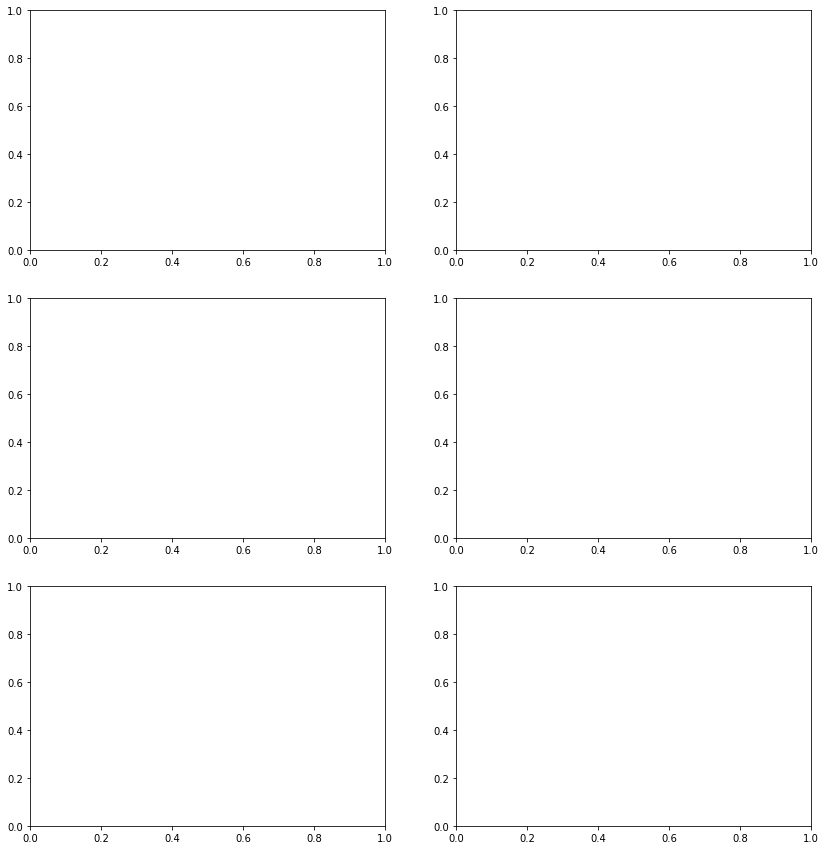

In [53]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(3,2,figsize=(14, 15))

method = [fixed_lr_list, decay_lr_list, our_decay_lr_list,cyclic_lr_list, random_cyclic_lr_list]
names = ['Tasa de aprendizaje constante', 'Tasa de aprendizaje dereciente (PyTorch)', 'Tasa de aprendizaje dereciente (Propio)', 'Tasa de aprendizaje cíclica', 'Tasa de aprendizaje cíclica aleatoria']
i = 0
for a in range(3):
  for b in range(2):
    if(a==2 and b==1):
      break
    ax[a,b].plot(range(len(method[i]))[1:], 
            method[i][1:], 
            'black',
            marker = 'o')
    #ax[a,b].set_xlim([1, len(method[i])])
    #ax[a,b].set_ylim([0, max(method[i]) + 0.01])
    ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
    ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    #ax[a,b].xaxis.set_major_locator(MultipleLocator(len(method[i])//4))
    #ax[a,b].xaxis.set_minor_locator(MultipleLocator(len(method[i])//4))
    ax[a,b].set_title(names[i])
    i+=1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

## Tiempos por epoch

In [55]:
resultados_df[['name','val_acc','time','test_acc']].style.hide_index()

name,val_acc,time,test_acc
LBFGS With LS,95.91%,32.220000,95.59%
Adam,95.88%,4.170000,95.23%
LBFGS,95.25%,24.420000,94.6%
Our Decay,95.27%,30.380000,94.54%
SGDM,95.3%,31.950000,94.34%
RMSP,95.07%,31.350000,94.34%
Random Ciclico,95.15%,48.500000,94.17%
Ciclico,95.22%,58.000000,94.14%


## Convergencia en iteraciones

### Muestra: precisión en el conjunto de validación y prueba

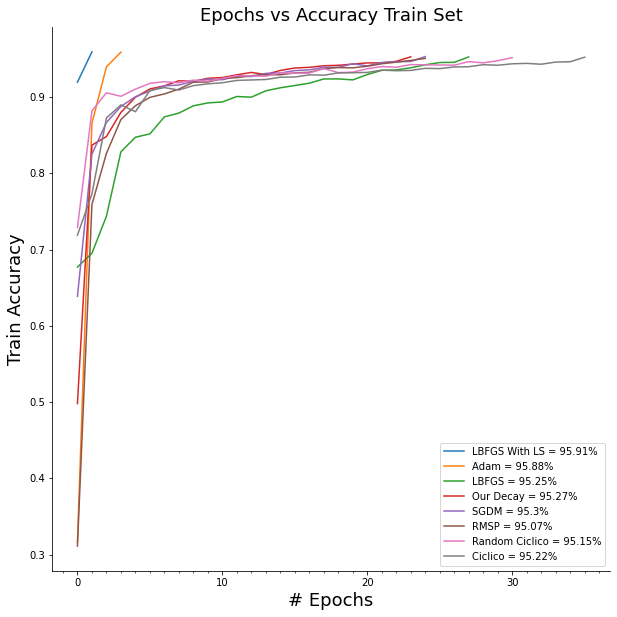

In [59]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 10))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

#ax.set_xlim([0, 50])
#ax.set_ylim([0, 1])

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

### Medida: costo

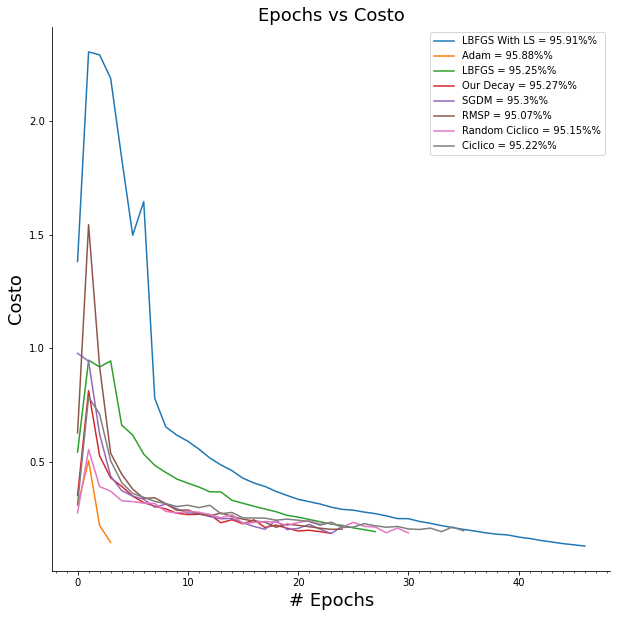

In [60]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 10))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = resultados_df.loc[k1,'val_acc']))

plt.title('Epochs vs Costo', fontsize = 18)


ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()